In [1]:
from datetime import datetime
from functools import partial
import warnings

import pandas as pd

from sklearn.preprocessing import LabelEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from tqdm.auto import tqdm

In [13]:
train1 = pd.read_csv('./data/train01.csv', sep=';')
train2 = pd.read_csv('./data/train02.csv', sep=';')
test = pd.read_csv('./data/test.csv', sep=';')

train1['split'] = 'train'
train2['split'] = 'val'
test['split'] = 'test'

In [14]:
train2 = train2[~(train2.id.isin(train1.id))].copy()

In [15]:
set(train1.id).intersection(set(train2.id))

set()

In [17]:
train1 = train1.reset_index(drop=True)
train2 = train2.reset_index(drop=True)
test = test.reset_index(drop=True)

In [18]:
train1.loc[~train1['x2'].isnull(), 'x2'] = train1.loc[~train1['x2'].isnull(), 'x2'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
train2.loc[~train2['x2'].isnull(), 'x2'] = train2.loc[~train2['x2'].isnull(), 'x2'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
test.loc[~test['x2'].isnull(), 'x2'] = test.loc[~test['x2'].isnull(), 'x2'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [22]:
def str_to_list(str_, sep=None):
    return list(map(float, str_[1:-1].split(sep))) 

def convert_str_to_list(df):
    for i in [8, 9]:
        df[f'x{i}'] = df[f'x{i}'].apply(str_to_list)

    for i in tqdm(range(10, 43)):
        df[f'x{i}'] = df[f'x{i}'].apply(partial(str_to_list, sep=', '))

aggrs = {
    'min': partial(np.nanmin, axis=1),
    'max': partial(np.nanmax, axis=1),
    'mean': partial(np.nanmean, axis=1),
    'median': partial(np.nanmedian, axis=1),
    'var': partial(np.nanvar, axis=1),
    'skew': lambda x: ((x - np.nanmean(x, axis=1, keepdims=True)) ** 3).mean(1) / np.nanstd(x, axis=1) ** 3,
    'kurt': lambda x: ((x - np.nanmean(x, axis=1, keepdims=True)) ** 4).mean(1) / np.nanstd(x, axis=1) ** 4,
    'p_25': partial(np.nanpercentile, q=25, axis=1),
    'p_75': partial(np.nanpercentile, q=75, axis=1),
    'p_nans': lambda x: np.isnan(x).mean(axis=1)
}

In [23]:
convert_str_to_list(train1)
convert_str_to_list(train2)
convert_str_to_list(test)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Разные размеры списков в столбцах "x8", "x9" в трейне/валидации/тесте, поэтому сделаем фичи с помощью агрегаций

In [24]:
def aggr_x8_x9(df):
    for col in ['x8', 'x9']:
        df_col = np.array(df[col].tolist())
        res = np.hstack([aggr(df_col).reshape(-1, 1) for aggr in aggrs.values()])
        res[np.isnan(res)] = 0.
        df = pd.concat([df, pd.DataFrame(res, columns=[col + '_' + k for k in aggrs.keys()])], axis=1)
    return df

In [25]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    train1 = aggr_x8_x9(train1)
    train2 = aggr_x8_x9(train2)
    test = aggr_x8_x9(test)

In [26]:
df = pd.concat([train1, train2, test])
del train1, train2, test

In [27]:
df.drop(['x8', 'x9'], axis=1, inplace=True)

In [28]:
nan_ratio = {}
for col in tqdm(df.columns):
    if col != 'y':
        nan_ratio[col] = df[col].explode().isnull().mean()

  0%|          | 0/63 [00:00<?, ?it/s]

### NaN ratio

<BarContainer object of 62 artists>

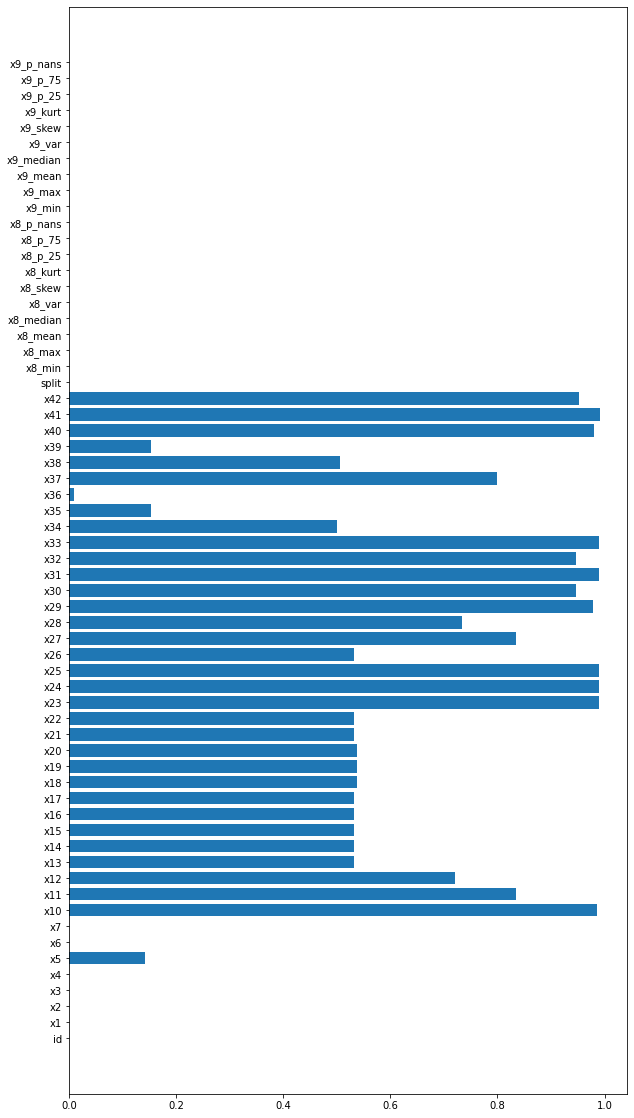

In [29]:
plt.figure(figsize=(10, 20))
plt.barh(list(nan_ratio.keys()), list(nan_ratio.values()))

Выкинем стобцы с большим количество NaN-ов

In [30]:
for k, v in nan_ratio.items():
    if v > 0.7:
        df.drop(k, axis=1, inplace=True)

In [31]:
df = df.reset_index(drop=True)

"Развернем" оставшиеся фичи-списки (у них длина во всех сетах одинакова)

In [32]:
list_cols = [
    'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 
    'x21', 'x22', 'x26', 'x34', 'x35', 'x36', 'x38', 'x39'
]

In [33]:
for col in tqdm(list_cols):
    item = df.loc[0, col]
    len_ = len(item)
    values = np.array(df[col].tolist())
    # Добавим фичу - количество NaN-ов в списке
    values = np.hstack([values, np.isnan(values).mean(1, keepdims=True)])
    # Сами NaN-ы заполним нулями
    values[np.isnan(values)] = 0.
    col_names = [f'{col}_{i}' for i in range(1, len_ + 1)] + [f'{col}_p_nans']
    df[col_names] = values
    df.drop(col, axis=1, inplace=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Заполним оставшиеся пропуски

In [34]:
df.loc[df['x2'].isnull(), 'x2'] = datetime(1, 1, 1, 0, 0, 0)
df.loc[df['x5'].isnull(), 'x5'] = -1

In [35]:
df['x2_month'] = df['x2'].apply(lambda x: x.month)
df['x2_day'] = df['x2'].apply(lambda x: x.day)

In [36]:
df.head()

,id,y,x1,x2,x3,x4,x5,x6,x7,split,...,x38_p_nans,x39_1,x39_2,x39_3,x39_4,x39_5,x39_6,x39_p_nans,x2_month,x2_day
0,-9196902500682081904,0.0,-2201458060675810556,2008-09-01 00:00:00,6312572492787112517,182,-6.347413e+18,2066976859146697559,0,train,...,1.0,80.46,80.46,80.46,80.46,80.46,80.46,0.0,9,1
1,-9196902500682081900,0.0,-2201458060675810556,2013-02-05 00:00:00,4293238556669161936,182,-8.465179e+18,-8648529837587014226,0,train,...,1.0,103.09,103.09,103.09,103.09,103.09,103.09,0.0,2,5
2,-9196902500682081899,0.0,-2201458060675810556,2008-09-01 00:00:00,6312572492787112517,175,5.417474e+18,-5480331477604673780,1,train,...,1.0,80.46,80.46,80.46,80.46,80.46,80.46,0.0,9,1
3,-9196902500682081897,0.0,-2201458060675810556,2008-09-01 00:00:00,6312572492787112517,182,-6.347413e+18,-3150357754345161454,0,train,...,1.0,80.46,80.46,80.46,80.46,80.46,80.46,0.0,9,1
4,-9196902500681081897,0.0,-2201458060675810556,2008-09-01 00:00:00,6312572492787112517,179,6.856367e+18,4900304581511328621,2,train,...,1.0,80.46,80.46,80.46,80.46,80.46,80.46,0.0,9,1


Эти фичи похожи на категориальные, транcформируем их значения в более приятные глазу

In [37]:
for col in ['x1', 'x3', 'x5', 'x6']:
    df[col] = LabelEncoder().fit_transform(df[col].values)

In [38]:
for col in df.columns:
    if df[col].dtype == np.int64:
        df[col] = df[col].astype(np.int32)
    if df[col].dtype == np.float64:
        df[col] = df[col].astype(np.float32)

In [39]:
df.to_csv('df_processed.csv', index=False)

In [40]:
df.drop(['id', 'x2'], axis=1, inplace=True)

In [41]:
train = df.loc[df['split'] == 'train'].copy()
val = df.loc[df['split'] == 'val'].copy()
test = df.loc[df['split'] == 'test'].copy()

train.drop('split', axis=1, inplace=True)
val.drop('split', axis=1, inplace=True)
test.drop('split', axis=1, inplace=True)

In [42]:
X_train = train.iloc[:, 1:].values
y_train = train['y'].values

X_val = val.iloc[:, 1:].values
y_val = val['y'].values

X_test = test.iloc[:, 1:].values

Чтобы не париться с нормализацией и one-hot кодированием, будем использовать градиентный бустинг

In [43]:
from catboost import CatBoostClassifier

In [44]:
cbc = CatBoostClassifier()

In [45]:
cbc.fit(X_train, y_train)

Learning rate set to 0.071017
0:	learn: 0.5574658	total: 84.6ms	remaining: 1m 24s
1:	learn: 0.4596122	total: 103ms	remaining: 51.5s
2:	learn: 0.3910542	total: 124ms	remaining: 41.4s
3:	learn: 0.3293452	total: 149ms	remaining: 37s
4:	learn: 0.2742301	total: 174ms	remaining: 34.7s
5:	learn: 0.2392018	total: 194ms	remaining: 32.2s
6:	learn: 0.2109678	total: 215ms	remaining: 30.5s
7:	learn: 0.1884776	total: 240ms	remaining: 29.8s
8:	learn: 0.1694177	total: 262ms	remaining: 28.9s
9:	learn: 0.1548701	total: 283ms	remaining: 28s
10:	learn: 0.1429103	total: 306ms	remaining: 27.5s
11:	learn: 0.1310188	total: 329ms	remaining: 27.1s
12:	learn: 0.1203791	total: 353ms	remaining: 26.8s
13:	learn: 0.1118815	total: 376ms	remaining: 26.5s
14:	learn: 0.1059695	total: 399ms	remaining: 26.2s
15:	learn: 0.1001842	total: 424ms	remaining: 26.1s
16:	learn: 0.0963688	total: 447ms	remaining: 25.9s
17:	learn: 0.0929830	total: 472ms	remaining: 25.7s
18:	learn: 0.0902010	total: 494ms	remaining: 25.5s
19:	learn: 0.

In [46]:
pred = cbc.predict_proba(X_val)

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(y_val, pred[:, 1])

0.9266422984316304

Не совпадает с результатами из презентации, но лика в данных вроде бы нет

In [51]:
test_pred = cbc.predict_proba(X_test)

In [52]:
sub = pd.DataFrame(np.hstack([np.arange(len(test_pred)).reshape(-1, 1), test_pred[:, 1, None]]), columns=['id', 'result'])
sub['id'] = sub['id'].astype(int)
sub = sub.set_index('id')

In [53]:
sub.to_csv('submission_catboost.csv', sep=';', index='id')

### Feature importance

In [49]:
order = np.argsort(cbc.feature_importances_)

<BarContainer object of 20 artists>

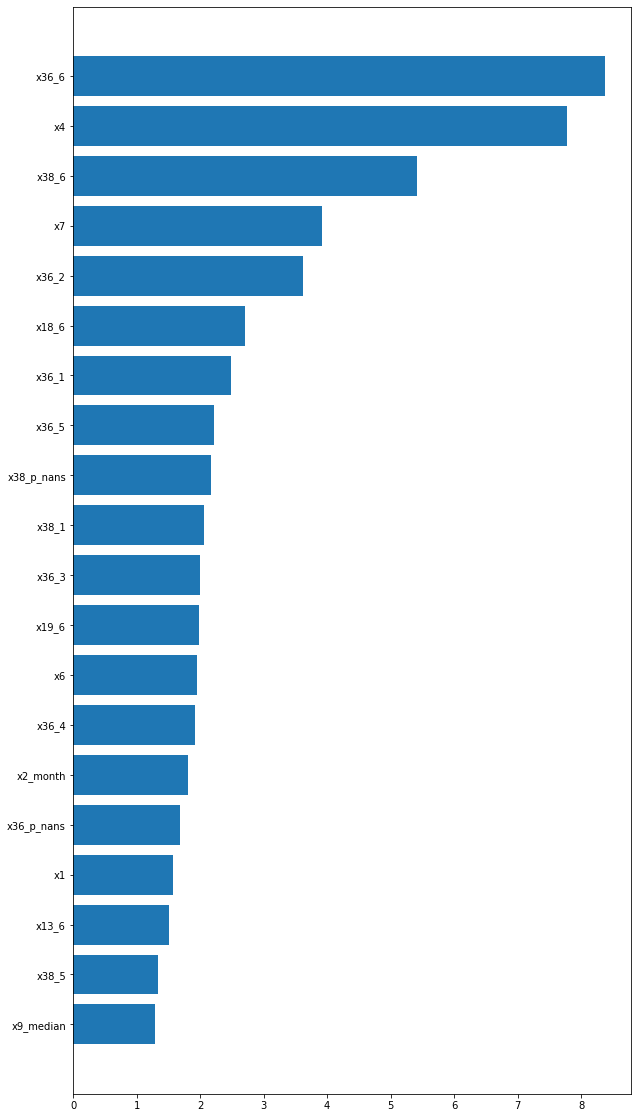

In [50]:
plt.figure(figsize=(10, 20))
plt.barh(train.columns[1:][order[::-1][:20]][::-1], cbc.feature_importances_[order[::-1][:20]][::-1])